## Packages

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt


## Irrelevant: Preprocess Data

In [ ]:
path = "../IDMT-Traffic/datasets/df_main.csv"
data = pd.read_csv(path) #data cleaning -> welche Daten nehmen wir, welche nicht? 
print(data.head(2))
print('-'*80)

# drop sampleposition, filename, UNnamed:0 columns
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.drop(["sample_pos"], axis=1, inplace=True)  
data.drop(["file"], axis=1, inplace=True)
data.drop(["Unnamed: 0"], axis=1, inplace=True)

print(data.head(2))
print('-'*80)

# amnalyse speed column
print(data["speed_kmh"])
print('-'*80)
data["speed_kmh"] = pd.to_numeric(data["speed_kmh"], errors="coerce")
print(data["speed_kmh"].value_counts(dropna=False).sort_index())
print('-'*80)

# mapping for encoding speed values
speed_mapping = {
    70.0: 0,
    50.0: 1,
    30.0: 2,
    np.nan: 3  
}

data["speed_kmh_encoded"] = data["speed_kmh"].map(speed_mapping)

print(data["speed_kmh_encoded"].value_counts().sort_index())

# Verify no NaN values remain in speed column
print(data["speed_kmh_encoded"].isnull().values.any())

## Load Data

In [3]:
data_path = '../IDMT-Traffic/datasets/df_main_encoded_only.csv'  
df = pd.read_csv(data_path)
df = df.drop(columns=['file', 'Unnamed: 0'])
print(df.head(2))
print('-'*80)


   is_background_encoded  date_time_encoded  location_encoded  \
0                      0                  0                 0   
1                      0                  0                 0   

   speed_kmh_encoded  daytime_encoded  weather_encoded  vehicle_encoded  \
0                  0                1                0                1   
1                  0                1                0                1   

   source_direction_encoded  microphone_encoded  channel_encoded  ...  \
0                         1                   0                0  ...   
1                         1                   1                1  ...   

   band_27_dB  band_28_dB  band_29_dB  peak_dB_1  peak_freq_1  peak_dB_2  \
0   37.024301   38.508511   35.946349  50.180933    31.622777  49.528332   
1   34.516289   34.960402   33.187933  54.903541  1000.000000  53.196406   

   peak_freq_2  peak_dB_3  peak_freq_3  octband_dB_mean  
0  1000.000000  47.901831   794.328235        42.383307  
1   794.32823

### Irrelevant: data loading old

In [59]:
data_path = '../IDMT-Traffic/datasets/df_main_encoded_only.csv'  
df = pd.read_csv(data_path)
df = df.drop(columns=['file', 'Unnamed: 0'])
print(df.head(2))
print('-'*80)
print(df["speed_kmh"].value_counts(dropna=False).sort_index())
print('-'*80)

# mapping for encoding speed values
speed_mapping = {
    "70": 0,
    "50": 1,
    "30": 2,
    "UNK": 3,
    np.nan: 3  
}

df["speed_kmh_encoded"] = df["speed_kmh"].map(speed_mapping)
print(df["speed_kmh_encoded"].value_counts().sort_index())
print(df["speed_kmh_encoded"].unique())

#delete old speed column and place new, encoded speed column
df = df.drop(columns=["speed_kmh"])
columns = list(df.columns)
columns.insert(3, columns.pop(columns.index("speed_kmh_encoded")))
df = df[columns]

# Verify no NaN values remain 
print(df.isnull().values.any())

df.to_csv('../Daytime-Classification/df_main_encoded_antonia.csv')

   is_background_encoded  date_time_encoded  location_encoded speed_kmh  \
0                      0                  0                 0        30   
1                      0                  0                 0        30   

   daytime_encoded  weather_encoded  vehicle_encoded  \
0                1                0                1   
1                1                0                1   

   source_direction_encoded  microphone_encoded  channel_encoded  ...  \
0                         1                   0                0  ...   
1                         1                   1                1  ...   

   band_27_dB  band_28_dB  band_29_dB  peak_dB_1  peak_freq_1  peak_dB_2  \
0   37.024301   38.508511   35.946349  50.180933    31.622777  49.528332   
1   34.516289   34.960402   33.187933  54.903541  1000.000000  53.196406   

   peak_freq_2  peak_dB_3  peak_freq_3  octband_dB_mean  
0  1000.000000  47.901831   794.328235        42.383307  
1   794.328235  51.942355   501.187234  

## Data Initialization & Split

In [ ]:
target = 'daytime_encoded'  # Zielvariable
X = df.drop(columns=[target])  # Features (alle Spalten außer 'daytime')
y = df[target]  # Zielvariable

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 1st split: train/ test 
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# 2nd split: train / validation 
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full)
# TRAIN 60% VAL 20% TEST 20%

# Ausgabe der Größen
print(f"Trainingsdaten: {X_train.shape}, Validierungsdaten: {X_val.shape}, Testdaten: {X_test.shape}")


Trainingsdaten: (5616, 58), Validierungsdaten: (1872, 58), Testdaten: (1873, 58)


## Initialize Model

In [24]:
logreg = LogisticRegression(max_iter=1000, random_state=42, C=2)

## Learning Curve Approach 

In [25]:
# Learning Curve berechnen
train_sizes, train_scores, val_scores = learning_curve(
    logreg,             # Dein Modell
    X_train,            # Trainingsdaten
    y_train,            # Zielvariable
    cv=5,               # Anzahl der Folds für Cross-Validation
    scoring="accuracy", # Metrik zur Bewertung
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 Stufen von 10% bis 100% der Trainingsdaten
    n_jobs=-1           # Parallelisierung für schnellere Berechnung
)

# Mittelwerte und Standardabweichungen der Scores berechnen
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)


### Learning Curve Visualisation

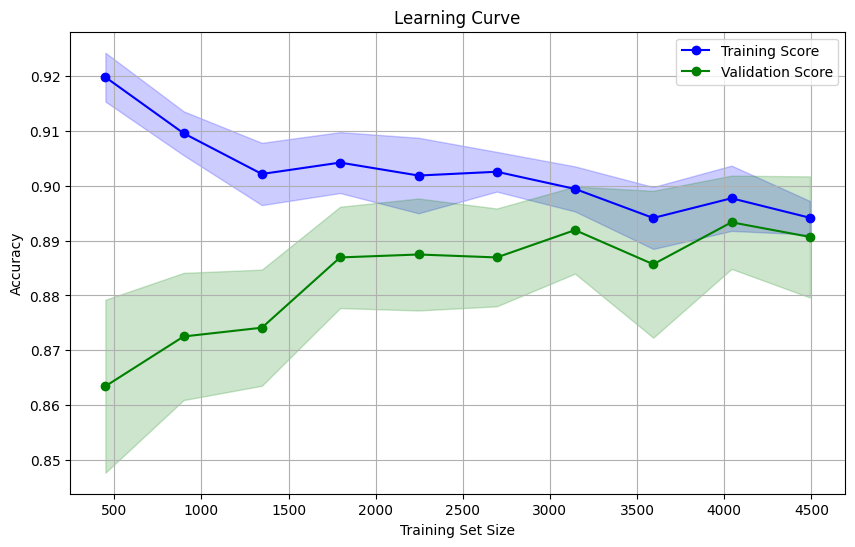

In [26]:
# Plot der Lernkurve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training Score")
plt.plot(train_sizes, val_mean, 'o-', color="green", label="Validation Score")

# Fülle die Bereiche für Standardabweichung
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color="green")

# Plot-Konfiguration
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()


## Train Model

In [6]:
# Trainieren des Modells
logreg.fit(X_train, y_train)


c:\Users\Anton\anaconda3\envs\traffic_noise\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

## Validate


In [9]:
y_val_pred = logreg.predict(X_val)

target_names = ['A', 'M']

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print('-'*80)

print("\nClassification Report:\n", classification_report(y_val, y_val_pred, target_names= target_names))
print('-'*80)

print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print('-'*80)

Validation Accuracy: 0.9011752136752137
--------------------------------------------------------------------------------

Classification Report:
               precision    recall  f1-score   support

           A       0.90      0.93      0.92      1095
           M       0.90      0.86      0.88       777

    accuracy                           0.90      1872
   macro avg       0.90      0.89      0.90      1872
weighted avg       0.90      0.90      0.90      1872

--------------------------------------------------------------------------------

Confusion Matrix:
 [[1021   74]
 [ 111  666]]
--------------------------------------------------------------------------------


## Test

In [10]:
y_test_pred = logreg.predict(X_test)

target_names = ['A', 'M']

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print('-'*80)

print("\nClassification Report:\n", classification_report(y_test, y_test_pred, target_names= target_names))
print('-'*80)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print('-'*80)

Test Accuracy: 0.9119060331019755
--------------------------------------------------------------------------------

Classification Report:
               precision    recall  f1-score   support

           A       0.91      0.95      0.93      1095
           M       0.92      0.86      0.89       778

    accuracy                           0.91      1873
   macro avg       0.91      0.90      0.91      1873
weighted avg       0.91      0.91      0.91      1873

--------------------------------------------------------------------------------

Confusion Matrix:
 [[1037   58]
 [ 107  671]]
--------------------------------------------------------------------------------


## Results

In [10]:
target_names = ['A', 'M']

print("Accuracy:", accuracy_score(y_test, y_pred))
print('-'*80)

print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names= target_names))
print('-'*80)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print('-'*80)

Accuracy: 0.899252402990388
--------------------------------------------------------------------------------

Classification Report:
               precision    recall  f1-score   support

           A       0.90      0.93      0.91      1642
           M       0.89      0.86      0.88      1167

    accuracy                           0.90      2809
   macro avg       0.90      0.89      0.90      2809
weighted avg       0.90      0.90      0.90      2809

--------------------------------------------------------------------------------

Confusion Matrix:
 [[1521  121]
 [ 162 1005]]
--------------------------------------------------------------------------------
